## Preprocessing

### 0. 사용 라이브러리

In [7]:
import pandas as pd
import numpy as np

from konlpy.tag import Okt
from konlpy.jvm import init_jvm # JVM을 초기화하는 함수 init_jvm을 제공

from pykospacing import Spacing # 한글 띄어쓰기 라이브러리
from hanspell import spell_checker # 한글 맞춤법 라이브러리
from tqdm import tqdm # 진행상황 Progress Bar를 위한 tqdm library

from tensorflow.keras.preprocessing.text import Tokenizer
 

### 1. 데이터 불러오기

In [8]:
# 데이터 불러오기

train_data = pd.read_table('./data/ratings_train.txt')
test_data = pd.read_table('./data/ratings_test.txt')

# 데이터 확인

print(train_data.info())# 150000 row
print(test_data.info()) # 50000 row

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB
None


### 2. 데이터 정제

#### 2.1 중복값 처리

In [9]:
# train_data 중복값 확인

print('train_data id 중복값: ', train_data['id'].notnull().sum() - len(train_data['id'].unique()))
print('train_data document 중복값: ', train_data['document'].notnull().sum() - len(train_data['document'].unique()))

print('train_data label 값: ', train_data['label'].unique(), '\n') # 0, 1

# test_data 중복값 확인

print('test_data id 중복값: ', test_data['id'].notnull().sum() - len(test_data['id'].unique()))
print('test_data document 중복값: ', test_data['document'].notnull().sum() - len(test_data['document'].unique()))

print('test_data label 값: ', test_data['label'].unique(), '\n') # 0, 1

# 중복값 제거

train_data.drop_duplicates(['document'], inplace=True)
test_data.drop_duplicates(['document'], inplace=True)

print('train data 개수: ', len(train_data))
print('test_data 개수: ', len(test_data))

train_data id 중복값:  0
train_data document 중복값:  3812
train_data label 값:  [0 1] 

test_data id 중복값:  0
test_data document 중복값:  839
test_data label 값:  [1 0] 

train data 개수:  146183
test_data 개수:  49158


#### 2.2 구두점, 특수문자 제거

In [10]:
train_data['document'] = train_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','') # [ㄱ - ㅎ, ㅏ - ㅣ, 가 - 핳] 제외 제거
train_data['document'] = train_data['document'].str.replace('^ +', '') # 화이트 스페이스 제거

test_data['document'] = test_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','')
test_data['document'] = test_data['document'].str.replace('^ +', '')

C:\Users\User\AppData\Local\Temp/ipykernel_10476/2848603368.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','') # [ㄱ - ㅎ, ㅏ - ㅣ, 가 - 핳] 제외 제거
C:\Users\User\AppData\Local\Temp/ipykernel_10476/2848603368.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', '') # 화이트 스페이스 제거
C:\Users\User\AppData\Local\Temp/ipykernel_10476/2848603368.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','')
C:\Users\User\AppData\Local\Temp/ipykernel_10476/2848603368.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', '')


#### 2.3 결측치 처리

In [11]:
# 결측치 확인


print(len(train_data[train_data['document']==""]), train_data['document'].isnull().sum()) # 비어있는 값("") 개수 확인
train_data.replace("", np.nan, inplace=True) # 비어있는 값("") 널값으로 변환

train_data[train_data['document'].isnull()==True]
print(train_data['document'].isnull().sum())

# 결측치 확인

print(len(test_data[test_data['document']==""]), test_data['document'].isnull().sum()) # 비어있는 값("") 개수 확인
test_data.replace("", np.nan, inplace=True) # 비어있는 값("") 널값으로 변환

test_data[test_data['document'].isnull()==True]
print(test_data['document'].isnull().sum())

# 결측치 제거

train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

# 결측치 확인

print(train_data['document'].isnull().sum(), test_data['document'].isnull().sum())
print(len(train_data), len(test_data))

789 1
790
305 1
306
0 0
145393 48852


### 3. 띄어쓰기, 맞춤법

In [12]:
spacing = Spacing()

test_sentence = train_data.iloc[1, 1]
spaced_sentence = spacing(test_sentence)
print(test_sentence)
print(spaced_sentence)

test_sentence = train_data.iloc[2, 1]
spaced_sentence = spacing(test_sentence)
print(test_sentence)
print(spaced_sentence)

test_sentence = train_data.iloc[10, 1]
spaced_sentence = spacing(test_sentence)
print(test_sentence)
print(spaced_sentence)

흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
흠포스터 보고 초딩 영화 줄오버 연기조차 가볍지 않구나
너무재밓었다그래서보는것을추천한다
너무 재밓었다 그래서 보는 것을 추천한다
걍인피니트가짱이다진짜짱이다
걍 인피니트가 짱이 다 진짜 짱이다


In [223]:
train_data['document'] = train_data['document'].apply(spacing)

In [72]:
test_data['document'] = test_data['document'].apply(spacing)

In [224]:
train_data.iloc[10]

id                      9008700
document    걍 인피니트가 짱이 다 진짜 짱이다
label                         1
Name: 10, dtype: object

In [73]:
test_data.iloc[10]

id                              8425305
document    한국독립영화의 한계 그렇게 아버지가 된다와 비교됨
label                                 0
Name: 11, dtype: object

In [227]:
spaced_train_data = train_data.copy()
spaced_train_data.to_csv('./data/ratings_train_spaced.csv', index=False)

In [75]:
spaced_test_data = test_data.copy()
spaced_test_data.to_csv('./data/ratings_test_spaced.csv', index=False)

### 띄어쓰기된 데이터 불러오기

In [13]:
train_data = pd.read_csv('./data/ratings_train_spaced.csv')

train_data

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터 보고 초딩 영화 줄오버 연기조차 가볍지 않구나,1
2,10265843,너무 재밓었다 그래서 보는 것을 추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬 페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어 보이기만 했던 커스...,1
...,...,...,...
145388,6222902,인간이 문제지 소는 뭔죄인가,0
145389,8549745,평점이 너무 낮아서,1
145390,9311800,이게 뭐 요 한국인은 거들 먹거리고 필리핀 혼혈은 착하다,0
145391,2376369,청춘 영화의 최고봉 방황과 우울했던 날들의 자화상,1


In [14]:
test_data = pd.read_csv('./data/ratings_test_spaced.csv')

test_data

,id,document,label
0,6270596,굳 ㅋ,1
1,8544678,뭐 야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
2,6825595,지루하지는 않은데 완전 막장 임 돈 주고 보기에는,0
3,6723715,만 아니었어도 별 다섯 개 줬을 텐데 왜 로 나와서 제 심기를 불편하게 하죠,0
4,7898805,음악이 주가 된 최고의 음악영화,1
...,...,...,...
48847,4608761,오랜만에 평점 로긴 했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
48848,5308387,의지 박약들이나 하는 거 다 탈영은 일단 주인공 김대희 닮았고 이 등 병 찐 따,0
48849,9072549,그림도 좋고 완성도도 높았지만 보는 내내 불안하게 만든다,0
48850,5802125,절대 봐서는 안 될 영화 재미도 없고 기분만 잡치고 한 세트장에서 다 해 먹네,0


### 3. 토큰화

형태소 분석기 종류

Okt(Open Korea Text), 메캅(Mecab), 코모란(Komoran), 한나눔(Hannanum), 꼬꼬마(Kkma)

#### 3.0 불용어 사전 불러오기

In [15]:
# 불용어 사전 불러오기
stopwords = pd.read_csv("./data/stopwords.csv", encoding='CP949')
stopwords = stopwords['stopwords']

stopwords_2 = pd.read_table("./data/stopwords_2.txt", names=['stopwords', '품사', 'ratio'])
stopwords_2 = stopwords_2['stopwords']

stopwords = pd.concat([stopwords, stopwords_2], axis=0)
stopwords.drop_duplicates(inplace=True)
stopwords.reset_index(inplace=True, drop=True)
print(len(stopwords))


664


#### 3.2 Mecab 사용 토큰화

In [16]:
test_sentence = train_data.iloc[10, 1]

In [17]:
from eunjeon import Mecab
mecab=Mecab()

print('메캅 형태소 분석 :',mecab.morphs(test_sentence))
print('메캅 품사 태깅 :',mecab.pos(test_sentence))
print('메캅 명사 추출 :',mecab.nouns(test_sentence))  

메캅 형태소 분석 : ['걍', '인피니트', '가', '짱', '이', '다', '진짜', '짱', '이', '다']
메캅 품사 태깅 : [('걍', 'UNKNOWN'), ('인피니트', 'NNP'), ('가', 'JKS'), ('짱', 'NNG'), ('이', 'JKS'), ('다', 'MAG'), ('진짜', 'MAG'), ('짱', 'NNG'), ('이', 'VCP'), ('다', 'EC')]
메캅 명사 추출 : ['인피니트', '짱', '짱']


In [18]:
mecab_x_train = []

for sentence in tqdm(train_data['document']): # 진행상황 Progress Bar를 위한 tqdm library
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    mecab_x_train.append(stopwords_removed_sentence)

100%|██████████| 145393/145393 [00:19<00:00, 7452.63it/s]


In [19]:
mecab_x_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = mecab.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    mecab_x_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [00:06<00:00, 7060.68it/s]


In [19]:
pd.Series(mecab_x_train).to_csv("./data/mecab_x_train.csv", index=False) 

In [20]:
pd.Series(mecab_x_test).to_csv("./data/mecab_x_test.csv", index=False)

In [26]:
mecab_x_train = pd.read_csv('./data/mecab_x_train.csv', encoding='UTF8')
mecab_x_train

,0
0,"['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리']"
1,"['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기'..."
2,"['너무', '재', '밓었다', '그래서', '보', '는', '것', '을', ..."
3,"['교도소', '이야기', '구먼', '솔직히', '재미', '는', '없', '다..."
4,"['사이몬', '페그', '의', '익살', '스런', '연기', '가', '돋보였..."
...,...
145388,"['인간', '이', '문제지', '소', '는', '뭔', '죄', '인가']"
145389,"['평점', '이', '너무', '낮', '아서']"
145390,"['이게', '뭐', '요', '한국인', '은', '거들', '먹거리', '고',..."
145391,"['청춘', '영화', '의', '최고봉', '방황', '과', '우울', '했',..."


In [27]:
mecab_x_test = pd.read_csv('./data/mecab_x_test.csv')
mecab_x_test

,0
0,"['굳', 'ㅋ']"
1,"['뭐', '야', '이', '평점', '들', '은', '나쁘', '진', '않'..."
2,"['지루', '하', '지', '는', '않', '은데', '완전', '막장', '..."
3,"['만', '아니', '었', '어도', '별', '다섯', '개', '줬', '을..."
4,"['음악', '이', '주가', '된', '최고', '의', '음악', '영화']"
...,...
48847,"['오랜만', '에', '평점', '로', '긴', '했', '네', 'ㅋㅋ', '..."
48848,"['의지', '박약', '들', '이나', '하', '는', '거', '다', '탈..."
48849,"['그림', '도', '좋', '고', '완성도', '도', '높', '았', '지..."
48850,"['절대', '봐서', '는', '안', '될', '영화', '재미', '도', '..."


In [20]:
mecab_x_test

[['굳', 'ㅋ'],
 ['뭐',
  '야',
  '이',
  '평점',
  '들',
  '은',
  '나쁘',
  '진',
  '않',
  '지만',
  '점',
  '짜리',
  '는',
  '더더욱',
  '아니',
  '잖아'],
 ['지루',
  '하',
  '지',
  '는',
  '않',
  '은데',
  '완전',
  '막장',
  '임',
  '돈',
  '주',
  '고',
  '보',
  '기',
  '에',
  '는'],
 ['만',
  '아니',
  '었',
  '어도',
  '별',
  '다섯',
  '개',
  '줬',
  '을',
  '텐데',
  '왜',
  '로',
  '나와서',
  '제',
  '심기',
  '를',
  '불편',
  '하',
  '게',
  '하',
  '죠'],
 ['음악', '이', '주가', '된', '최고', '의', '음악', '영화'],
 ['진정', '한', '쓰레기'],
 ['마치',
  '미국',
  '애니',
  '에서',
  '튀어나온',
  '듯',
  '한',
  '창의력',
  '없',
  '는',
  '로봇',
  '디자인',
  '부터',
  '가',
  '고개',
  '를',
  '젖',
  '게',
  '한다'],
 ['갈수록',
  '개판',
  '되',
  '가',
  '는',
  '중국',
  '영화',
  '유치',
  '하',
  '고',
  '내용',
  '없',
  '음',
  '폼',
  '잡',
  '다',
  '끝',
  '남',
  '말',
  '도',
  '안',
  '되',
  '는',
  '무기',
  '에',
  '유치',
  '한',
  '남무',
  '아',
  '그립',
  '다',
  '동사서독',
  '같',
  '은',
  '영화',
  '가',
  '이건',
  '류',
  '아류',
  '작',
  '이',
  '다'],
 ['이별',
  '의',
  '아픔',
  '뒤',
  '에',
  '찾아오',
  '는',
  '새로운',
 

In [21]:
# 빈도 수 확인

from nltk import FreqDist

vocab = FreqDist(np.hstack(mecab_x_train))
vocab.most_common()

[('이', 80598),
 ('는', 68358),
 ('다', 59226),
 ('영화', 57761),
 ('고', 47444),
 ('하', 44942),
 ('가', 35130),
 ('도', 34300),
 ('의', 34029),
 ('은', 31614),
 ('에', 31483),
 ('을', 29981),
 ('한', 27454),
 ('보', 24916),
 ('게', 22451),
 ('들', 21604),
 ('지', 20301),
 ('를', 17091),
 ('없', 17007),
 ('있', 16786),
 ('나', 14037),
 ('좋', 13652),
 ('만', 12235),
 ('었', 12184),
 ('너무', 11303),
 ('는데', 10888),
 ('어', 10366),
 ('안', 10274),
 ('봤', 10234),
 ('로', 10208),
 ('적', 10060),
 ('기', 9817),
 ('거', 9811),
 ('정말', 9773),
 ('아', 9701),
 ('음', 9403),
 ('것', 9338),
 ('으로', 9325),
 ('네요', 8808),
 ('재밌', 8793),
 ('지만', 8749),
 ('같', 8627),
 ('진짜', 8404),
 ('네', 8315),
 ('했', 8094),
 ('에서', 8075),
 ('점', 7936),
 ('않', 7735),
 ('수', 7706),
 ('인', 7627),
 ('았', 7622),
 ('되', 7490),
 ('과', 7390),
 ('면', 7370),
 ('ㅋㅋ', 7227),
 ('말', 7146),
 ('연기', 7122),
 ('잘', 6641),
 ('주', 6627),
 ('내', 6602),
 ('던', 6413),
 ('최고', 6307),
 ('평점', 6260),
 ('이런', 6011),
 ('해', 5959),
 ('와', 5957),
 ('생각', 5722),
 ('할', 5705),
 

In [40]:
mecab_x_train

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나'],
 ['너무', '재', '밓었다', '그래서', '보', '는', '것', '을', '추천', '한다'],
 ['교도소', '이야기', '구먼', '솔직히', '재미', '는', '없', '다', '평점', '조정'],
 ['사이몬',
  '페그',
  '의',
  '익살',
  '스런',
  '연기',
  '가',
  '돋보였',
  '던',
  '영화',
  '스파이더맨',
  '에서',
  '늙',
  '어',
  '보이',
  '기',
  '만',
  '했',
  '던',
  '커스틴',
  '던스트',
  '가',
  '너무나',
  '도',
  '이',
  '뻐',
  '보였',
  '다'],
 ['막',
  '걸음마',
  '뗀',
  '세',
  '부터',
  '초등',
  '학교',
  '학년',
  '생',
  '인',
  '살용',
  '영화',
  'ㅋㅋㅋ',
  '별반',
  '개',
  '도',
  '아까움'],
 ['원작', '의', '긴장감', '을', '제대로', '살려', '내', '지', '못했', '다'],
 ['별',
  '반개',
  '도',
  '아깝',
  '다',
  '욕',
  '나온',
  '다',
  '이',
  '응',
  '경',
  '길용우',
  '연기',
  '생활',
  '이',
  '몇',
  '년',
  '인지',
  '정말',
  '발',
  '로',
  '해도',
  '그것',
  '보단',
  '낫',
  '겟',
  '다',
  '납치',
  '감금',
  '만',
  '반복',
  '반복',
  '이',
  '드라마',
  '는',
  '가족',
  '도',
  '없',
  '다',
  '연기',
  '못',
  '하',
  '는',
  '사람',
  '만',
  '

### 4. 정수 인코딩

#### 4.2 Mecab 데이터 정수 인코딩

In [22]:
mecab_x_train = pd.read_csv('./data/mecab_x_train.csv')
mecab_x_train = pd.Series(mecab_x_train['0'])
mecab_x_train

mecab_x_test = pd.read_csv('./data/mecab_x_test.csv')
mecab_x_test = pd.Series(mecab_x_test['0'])
mecab_x_test

0                                               ['굳', 'ㅋ']
1        ['뭐', '야', '이', '평점', '들', '은', '나쁘', '진', '않'...
2        ['지루', '하', '지', '는', '않', '은데', '완전', '막장', '...
3        ['만', '아니', '었', '어도', '별', '다섯', '개', '줬', '을...
4            ['음악', '이', '주가', '된', '최고', '의', '음악', '영화']
                               ...                        
48847    ['오랜만', '에', '평점', '로', '긴', '했', '네', 'ㅋㅋ', '...
48848    ['의지', '박약', '들', '이나', '하', '는', '거', '다', '탈...
48849    ['그림', '도', '좋', '고', '완성도', '도', '높', '았', '지...
48850    ['절대', '봐서', '는', '안', '될', '영화', '재미', '도', '...
48851                         ['마무리', '는', '또', '왜', '이래']
Name: 0, Length: 48852, dtype: object

In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(mecab_x_train)

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합(vocabulary)의 크기 : 45131
등장 빈도가 2번 이하인 희귀 단어의 수: 24448
단어 집합에서 희귀 단어의 비율: 54.1711905342226
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.2501063601333857
단어 집합의 크기 : 20684


In [24]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(mecab_x_train)
X_train_mecab = tokenizer.texts_to_sequences(mecab_x_train)
X_test_mecab = tokenizer.texts_to_sequences(mecab_x_test)

In [25]:
test_data

,id,document,label
0,6270596,굳 ㅋ,1
1,8544678,뭐 야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
2,6825595,지루하지는 않은데 완전 막장 임 돈 주고 보기에는,0
3,6723715,만 아니었어도 별 다섯 개 줬을 텐데 왜 로 나와서 제 심기를 불편하게 하죠,0
4,7898805,음악이 주가 된 최고의 음악영화,1
...,...,...,...
48847,4608761,오랜만에 평점 로긴 했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
48848,5308387,의지 박약들이나 하는 거 다 탈영은 일단 주인공 김대희 닮았고 이 등 병 찐 따,0
48849,9072549,그림도 좋고 완성도도 높았지만 보는 내내 불안하게 만든다,0
48850,5802125,절대 봐서는 안 될 영화 재미도 없고 기분만 잡치고 한 세트장에서 다 해 먹네,0


In [26]:
y_train_mecab = np.array(train_data['label'])
y_test_mecab = np.array(test_data['label'])

### 5. 패딩

In [27]:
drop_train = [index for index, sentence in enumerate(X_train_mecab) if len(sentence) < 1]

In [28]:
X_train_mecab = np.delete(X_train_mecab, drop_train, axis=0)
y_train_mecab = np.delete(y_train_mecab, drop_train, axis=0)
print(len(X_train_mecab))
print(len(y_train_mecab))

145278
145278


C:\Users\User\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 96
리뷰의 평균 길이 : 16.77595368878977


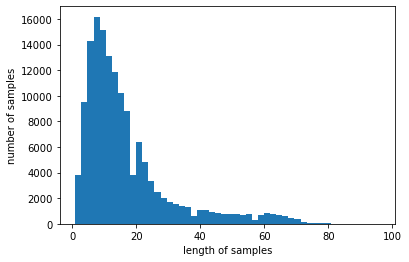

In [29]:
import matplotlib.pyplot as plt

print('리뷰의 최대 길이 :',max(len(review) for review in X_train_mecab))
print('리뷰의 평균 길이 :',sum(map(len, X_train_mecab))/len(X_train_mecab))
plt.hist([len(review) for review in X_train_mecab], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [30]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 45
below_threshold_len(max_len, X_train_mecab)

전체 샘플 중 길이가 45 이하인 샘플의 비율: 93.57851842674046


In [31]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_mecab = pad_sequences(X_train_mecab, maxlen=max_len)
X_test_mecab = pad_sequences(X_test_mecab, maxlen=max_len)

In [32]:
print(len(X_train_mecab), len(X_test_mecab), len(y_train_mecab), len(y_test_mecab))

145278 48852 145278 48852


In [33]:
temp = pd.DataFrame(X_train_mecab)
temp.to_csv('./data/temp_dataset/X_train_mecab.csv', index=False)
temp = pd.DataFrame(X_test_mecab)
temp.to_csv('./data/temp_dataset/X_test_mecab.csv', index=False)
temp = pd.DataFrame(y_train_mecab)
temp.to_csv('./data/temp_dataset/y_train_mecab.csv', index=False)
temp = pd.DataFrame(y_test_mecab)
temp.to_csv('./data/temp_dataset/y_test_mecab.csv', index=False)

In [34]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train_mecab, y_train_mecab, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1816/1816 [==============================] - 119s 64ms/step - loss: 0.3910 - acc: 0.8238 - val_loss: 0.3496 - val_acc: 0.8468

Epoch 00001: val_acc improved from -inf to 0.84681, saving model to best_model.h5
Epoch 2/15
1816/1816 [==============================] - 127s 70ms/step - loss: 0.3226 - acc: 0.8619 - val_loss: 0.3231 - val_acc: 0.8613

Epoch 00002: val_acc improved from 0.84681 to 0.86134, saving model to best_model.h5
Epoch 3/15
1816/1816 [==============================] - 128s 70ms/step - loss: 0.2938 - acc: 0.8767 - val_loss: 0.3221 - val_acc: 0.8594

Epoch 00003: val_acc did not improve from 0.86134
Epoch 4/15
1816/1816 [==============================] - 133s 73ms/step - loss: 0.2738 - acc: 0.8868 - val_loss: 0.3102 - val_acc: 0.8666

Epoch 00004: val_acc improved from 0.86134 to 0.86660, saving model to best_model.h5
Epoch 5/15
1816/1816 [==============================] - 123s 68ms/step - loss: 0.2563 - acc: 0.8954 - val_loss: 0.3182 - val_acc: 0.8669

Epoch 00

In [35]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test_mecab, y_test_mecab)[1]))

1527/1527 [==============================] - 16s 10ms/step - loss: 0.3235 - acc: 0.8655

 테스트 정확도: 0.8655
